In [3]:


# 2. Install nnU-Net V2 (and hidden dependencies)
print("Installing nnU-Net...")
!pip install nnunetv2
!pip install --upgrade git+https://github.com/FabianIsensee/hiddenlayer.git


Installing nnU-Net...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 kB 11.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 10.0 MB/s eta 0:00:00
  Created wheel for nnunetv2: 

  Cloning https://github.com/FabianIsensee/hiddenlayer.git to /tmp/pip-req-build-8bp9p4bu
  Running command git clone --filter=blob:none --quiet https://github.com/FabianIsensee/hiddenlayer.git /tmp/pip-req-build-8bp9p4bu
  Resolved https://github.com/FabianIsensee/hiddenlayer.git to commit b7263b6dc4569da1b6dea5964e1eac78fa32fa77
  Preparing metadata (setup.py) ... done
  Created wheel for hiddenlayer: filename=hiddenlayer-0.2-py3-none-any.whl size=20004 sha256=e0fb124db11cb02c3cfbc63ce42f66c27353494f00506b595ffd05daa59c9377
  Stored in directory: /tmp/pip-ephem-wheel-cache-1fcuwill/wheels/87/95/c2/988265e8d5046e61a213ee5000db03954c7a5eaa7febcf82a3
Successfully built hiddenlayer


In [1]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import nnunetv2

In [3]:

import os

# 3. Define Environment Variables
# nnU-Net requires these to know where to look.
# We will set them to folders inside the fast local Colab storage (/content)
os.environ['nnUNet_raw'] = "/content/nnUNet_raw"
os.environ['nnUNet_preprocessed'] = "/content/nnUNet_preprocessed"
os.environ['nnUNet_results'] = "/content/drive/MyDrive/nnUNet_results" # Save results back to Drive!

# Create these folders
!mkdir -p $nnUNet_raw
!mkdir -p $nnUNet_preprocessed
!mkdir -p $nnUNet_results


In [4]:

# 4. Copy and Unzip Data
# Replace 'nnUNet_raw.zip' with the exact name/path of your zip file on Drive
zip_path = "/content/drive/MyDrive/nnUNet_raw.zip"

if os.path.exists(zip_path):
    print("Copying data from Drive to Colab VM (this speeds up training)...")
    !cp "{zip_path}" /content/temp_data.zip

    print("Unzipping data...")
    # -q means quiet (don't print every filename), -d specifies destination
    !unzip -q /content/temp_data.zip -d /content/nnUNet_raw

    # Clean up zip to save space
    !rm /content/temp_data.zip

    # Verify structure (Fix nesting if necessary)
    # Sometimes zipping creates nnUNet_raw/nnUNet_raw/Dataset500...
    # This ensures the dataset is right where env var points
    if os.path.exists("/content/nnUNet_raw/nnUNet_raw"):
        print("Fixing nested folder structure...")
        !mv /content/nnUNet_raw/nnUNet_raw/* /content/nnUNet_raw/
        !rmdir /content/nnUNet_raw/nnUNet_raw

    print("Data setup complete!")
else:
    print(f"Error: Could not find {zip_path}. Check your filename.")

Copying data from Drive to Colab VM (this speeds up training)...
Unzipping data...
Fixing nested folder structure...
Data setup complete!


In [5]:
 !ls /content/nnUNet_raw

Dataset500_BraTS2020


In [10]:
import os
import shutil
import gzip
import nibabel as nib
from tqdm import tqdm

# Define your labels directory
labels_dir = "/content/nnUNet_raw/Dataset500_BraTS2020/labelsTr"

print(f"Scanning for fake .gz files in: {labels_dir}")

files = [f for f in os.listdir(labels_dir) if f.endswith(".nii.gz")]
fixed_count = 0

for f in tqdm(files):
    file_path = os.path.join(labels_dir, f)

    try:
        # 1. Try to open it as a normal gzip file
        with gzip.open(file_path, 'rb') as check:
            check.read(1)
            # If this succeeds, it is truly gzipped. Do nothing.

    except (gzip.BadGzipFile, OSError):
        # 2. If it fails, it's likely an uncompressed .nii file
        # We will rename it to .nii, load it, and save it back as a proper .nii.gz

        temp_nii_path = file_path[:-3] # remove .gz extension

        # Rename file on disk to .nii so nibabel reads it correctly
        os.rename(file_path, temp_nii_path)

        try:
            # Load the raw .nii
            img = nib.load(temp_nii_path)

            # Save it back as a REAL .nii.gz
            nib.save(img, file_path)

            # Clean up the .nii
            if os.path.exists(temp_nii_path):
                os.remove(temp_nii_path)

            fixed_count += 1

        except Exception as e:
            print(f"Failed to fix {f}: {e}")
            # Restore original name if fix failed so we don't lose data
            if os.path.exists(temp_nii_path):
                os.rename(temp_nii_path, file_path)

print(f"\n✅ Processing complete.")
print(f"🔧 Fixed {fixed_count} files that were uncompressed but named .gz")


Scanning for fake .gz files in: /content/nnUNet_raw/Dataset500_BraTS2020/labelsTr


100%|██████████| 368/368 [00:16<00:00, 21.84it/s]


✅ Processing complete.
🔧 Fixed 368 files that were uncompressed but named .gz


In [11]:
import os
import json
import nibabel as nib
import numpy as np
from tqdm import tqdm

# Paths
dataset_root = "/content/nnUNet_raw/Dataset500_BraTS2020"
labels_dir = os.path.join(dataset_root, "labelsTr")
json_path = os.path.join(dataset_root, "dataset.json")

# --- PART 1: Remap Label 4 -> 3 in Images ---
print(f"🔄 Remapping labels (4 -> 3) in: {labels_dir}")
files = [f for f in os.listdir(labels_dir) if f.endswith(".nii.gz")]

for f in tqdm(files):
    file_path = os.path.join(labels_dir, f)

    # Load
    img = nib.load(file_path)
    data = img.get_fdata()

    # Remap if necessary
    if 4 in data:
        data[data == 4] = 3

        # Save back
        new_img = nib.Nifti1Image(data, img.affine, img.header)
        nib.save(new_img, file_path)

print("✅ Images remapped successfully.")

# --- PART 2: Fix dataset.json ---
print(f"\n📝 Updating dataset.json...")

if os.path.exists(json_path):
    with open(json_path, 'r') as f:
        json_data = json.load(f)

    # Check current labels
    print(f"Old labels: {json_data.get('labels', 'Not found')}")

    # FORCE the correct consecutive labels
    json_data['labels'] = {
        "0": "background",
        "1": "necrotic",
        "2": "edema",
        "3": "enhancing"
    }

    # BraTS usually has 'channel_names' or 'modality'.
    # Ensure region_class_order matches if present (nnU-Net v2 specific)
    # But usually, just fixing 'labels' is enough for the basic check.

    with open(json_path, 'w') as f:
        json.dump(json_data, f, indent=4)

    print(f"New labels: {json_data['labels']}")
    print("✅ dataset.json updated.")
else:
    print("❌ Error: dataset.json not found!")

🔄 Remapping labels (4 -> 3) in: /content/nnUNet_raw/Dataset500_BraTS2020/labelsTr


100%|██████████| 368/368 [01:19<00:00,  4.64it/s]

✅ Images remapped successfully.

📝 Updating dataset.json...
Old labels: {'background': 0, 'edema': 2, 'non_enhancing_tumor': 1, 'enhancing_tumor': 4}
New labels: {'0': 'background', '1': 'necrotic', '2': 'edema', '3': 'enhancing'}
✅ dataset.json updated.


In [13]:
import json
import os

json_path = "/content/nnUNet_raw/Dataset500_BraTS2020/dataset.json"

print("Reading current JSON...")
if os.path.exists(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)

    # 1. FIX LABELS
    # Keys must be strings "0", "1", "2"... NOT integers 0, 1, 2
    # Label 0 must be strictly "background"
    correct_labels = {
        "0": "background",
        "1": "necrotic",
        "2": "edema",
        "3": "enhancing"
    }

    data['labels'] = correct_labels

    # 2. FIX CHANNEL NAMES (just in case)
    # Ensure keys are strings "0", "1", "2"...
    if 'channel_names' in data:
        new_channels = {str(k): v for k, v in data['channel_names'].items()}
        data['channel_names'] = new_channels

    # 3. REMOVE regions_class_order if present
    # It can cause conflicts if not perfectly defined.
    # nnU-Net v2 can infer regions from 'labels' automatically for standard tasks.
    if 'regions_class_order' in data:
        print("Removing 'regions_class_order' to let nnU-Net handle it automatically...")
        del data['regions_class_order']

    # 4. SAVE
    print("Writing corrected JSON...")
    with open(json_path, 'w') as f:
        json.dump(data, f, indent=4)

    print("✅ dataset.json fixed. Content:")
    print(json.dumps(data['labels'], indent=4))

else:
    print("❌ Error: dataset.json not found.")

Reading current JSON...
Writing corrected JSON...
✅ dataset.json fixed. Content:
{
    "0": "background",
    "1": "necrotic",
    "2": "edema",
    "3": "enhancing"
}


In [15]:
import json
import os

json_path = "/content/nnUNet_raw/Dataset500_BraTS2020/dataset.json"

if os.path.exists(json_path):
    print("Reading dataset.json...")
    with open(json_path, 'r') as f:
        data = json.load(f)

    current_labels = data.get('labels', {})
    print(f"Current labels: {current_labels}")

    # Check if we need to flip
    # If keys are digits ("0", "1"), we FLIP them to be values
    if "0" in current_labels:
        print("🔄 Detected 'Index -> Name' format. Flipping to 'Name -> Index'...")

        # Create new reversed dictionary (Name -> Int)
        new_labels = {v: int(k) for k, v in current_labels.items()}

        # Ensure 'background' is lowercase
        # Sometimes it might be 'Background', fix that just in case
        final_labels = {}
        for k, v in new_labels.items():
            final_labels[k.lower()] = v

        data['labels'] = final_labels

        # Save back to disk
        with open(json_path, 'w') as f:
            json.dump(data, f, indent=4)

        print("✅ Fixed! New labels section looks like this:")
        print(json.dumps(data['labels'], indent=4))

    elif "background" in current_labels:
        print("✅ Labels are already in 'Name -> Index' format. No changes needed.")

    else:
        print("❌ Warning: Could not find '0' or 'background' in labels. Check file manually.")

else:
    print(f"❌ Error: File not found at {json_path}")

Reading dataset.json...
Current labels: {'0': 'background', '1': 'necrotic', '2': 'edema', '3': 'enhancing'}
🔄 Detected 'Index -> Name' format. Flipping to 'Name -> Index'...
✅ Fixed! New labels section looks like this:
{
    "background": 0,
    "necrotic": 1,
    "edema": 2,
    "enhancing": 3
}


In [16]:
!nnUNetv2_plan_and_preprocess -d 500 --verify_dataset_integrity

Fingerprint extraction...
Dataset500_BraTS2020
Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer

####################
verify_dataset_integrity Done. 
If you didn't see any error messages then your dataset is most likely OK!
####################

Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer
100% 368/368 [05:27<00:00,  1.12it/s]
Experiment planning...

############################
INFO: You are using the old nnU-Net default planner. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Dropping 3d_lowres config because the image size difference to 3d_fullres is too small. 3d_fullres: [139. 170. 138.], 3d_lowres: [139, 170, 138]
2D U-Net configuration:
{'data_identifier': 'nnUNetPlans_2d', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 105, 'patch_size': (np.

In [17]:
import shutil
import os

# Define paths
# source = where nnU-Net put the files
source_folder = "/content/nnUNet_preprocessed"
# destination = your Google Drive
output_filename = "/content/drive/MyDrive/nnUNet_preprocessed_BraTS_Ready"

print(f"📦 Zipping '{source_folder}' to Google Drive...")
print("This can take 5-10 minutes. Please keep the browser tab open.")

# Create the zip file
shutil.make_archive(output_filename, 'zip', source_folder)

print(f"✅ DONE! Saved as: {output_filename}.zip")

📦 Zipping '/content/nnUNet_preprocessed' to Google Drive...
This can take 5-10 minutes. Please keep the browser tab open.
✅ DONE! Saved as: /content/drive/MyDrive/nnUNet_preprocessed_BraTS_Ready.zip


In [ ]:
#Testing training run
!nnUNetv2_train 500 3d_fullres 0


############################
INFO: You are using the old nnU-Net default plans. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2025-12-29 14:00:09.256390: Using torch.compile...
2025-12-29 14:00:13.725744: do_dummy_2d_data_aug: False
2025-12-29 14:00:13.758265: Creating new 5-fold cross-validation split...
2025-12-29 14:00:13.780367: Desired fold for training: 0
2025-12-29 14:00:13.789324: This split has 294 training an

Training worked 

In [24]:
!pip install blosc2

🎲 Random Selection: BraTS20_Training_296.b2nd
🔪 Viewing Slice: 79 (out of 130)


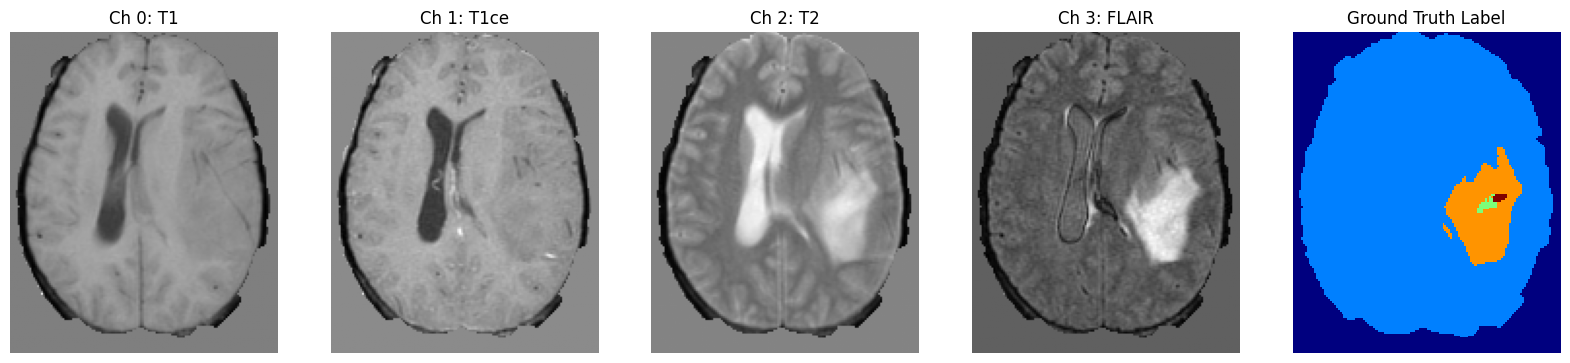

In [32]:
import os
import numpy as np
import blosc2
import matplotlib.pyplot as plt
import random  # Import random to pick different files

# 1. Define path
preprocessed_dir = "/content/nnUNet_preprocessed/Dataset500_BraTS2020/nnUNetPlans_3d_fullres"

# 2. Find all .b2nd files (excluding segmentation files)
files = [f for f in os.listdir(preprocessed_dir) if f.endswith(".b2nd") and not "_seg" in f]

if len(files) > 0:
    # --- CHANGE IS HERE: Pick a random file from the list ---
    sample_file = random.choice(files)

    file_path = os.path.join(preprocessed_dir, sample_file)
    seg_path = os.path.join(preprocessed_dir, sample_file.replace(".b2nd", "_seg.b2nd"))

    print(f"🎲 Random Selection: {sample_file}")

    # 3. Load the data using Blosc2
    try:
        image_data = blosc2.open(file_path, mode='r')[:]

        if os.path.exists(seg_path):
            label_data = blosc2.open(seg_path, mode='r')[:]
            has_label = True
        else:
            has_label = False

        # 4. Select a random slice (somewhere in the middle 50% of the brain to avoid empty edges)
        depth = image_data.shape[1]
        slice_idx = random.randint(int(depth * 0.3), int(depth * 0.7))
        print(f"🔪 Viewing Slice: {slice_idx} (out of {depth})")

        # 5. Visualize
        fig, ax = plt.subplots(1, 5, figsize=(20, 5))

        channel_names = ["T1", "T1ce", "T2", "FLAIR"]

        for i in range(4):
            ax[i].imshow(image_data[i, slice_idx, :, :], cmap='gray')
            ax[i].set_title(f"Ch {i}: {channel_names[i]}")
            ax[i].axis('off')

        # Ground Truth Label
        if has_label:
            ax[4].imshow(label_data[0, slice_idx, :, :], cmap='jet', interpolation='nearest')
            ax[4].set_title("Ground Truth Label")
            ax[4].axis('off')
        else:
            ax[4].text(0.5, 0.5, "No Label File", ha='center')

        plt.show()
    except Exception as e:
        print(f"⚠️ Error reading file {sample_file}: {e}")

else:
    print("❌ No files found. Check your directory path.")